In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, sys

sys.path.insert(0, '../src/Ostrich_support/')
from cal_metrics_NoRouting import *

In [3]:
path_bestmodel = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest/CAMELS_468_OstCalib/archive/PreserveBestModel'
add_flow_file = '/glade/p/ral/hap/common_data/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all/06447000_streamflow_qc.txt,/glade/p/ral/hap/common_data/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all/06450500_streamflow_qc.txt'
pathCTSM = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest/CAMELS_468'
ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest/CAMELS_468_OstCalib/refdata/streamflow_data.csv'

date_start='2001-01-01'      # start date for calculating statistics
date_end='2003-01-01'       # end date for calculating statistics

######## default variable names
clm_q_name = 'QRUNOFF' # default runoff variable name
clm_q_sdim = 'lndgrid' # spatial dim name
ref_q_name = 'Runoff_cms'
ref_q_date = 'Date'
keyword = ".clm2.h1."

CTSMfilelist = glob.glob(f'{path_bestmodel}/*{keyword}*nc')
CTSMfilelist.sort()

In [4]:
########################################################################################################################
# load CTSM streamflow (m3/s)
ds_simu = main_read_CTSM_streamflow(pathCTSM, CTSMfilelist, date_start, date_end, clm_q_name, clm_q_sdim)

########################################################################################################################
# load CAMELS observation streamflow (m3/s)
ds_q_obs = read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name)

########################################################################################################################
# add upstream flows to simulated streamflow
ds_simu = add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name)

########################################################################################################################
# evaluation

ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

kge_q = get_modified_KGE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)
rmse_q = get_RMSE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)

print("Calibration KGE':", kge_q)

Use streamflow reference file: /glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest/CAMELS_468_OstCalib/refdata/streamflow_data.csv
Flow files will be added to the incremental downstream basin: ['/glade/p/ral/hap/common_data/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all/06447000_streamflow_qc.txt', '/glade/p/ral/hap/common_data/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all/06450500_streamflow_qc.txt']
The valid ratio of simulated streamflow is 1.0 after add upstream flow
Calibration KGE': 0.6620696984933163


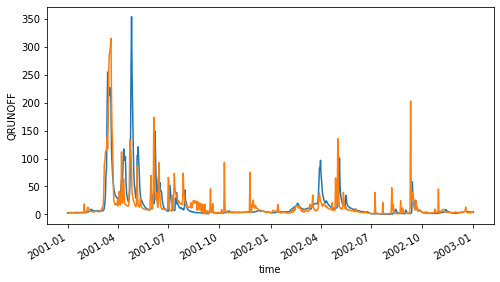

In [5]:
fig, ax = plt.subplots(figsize=[8, 4])
ds_q_obs.Runoff_cms.plot(ax=ax)
ds_simu.QRUNOFF.plot(ax=ax)